# Ensuring that offsets and other internationally transferred mitigation outcomes contribute effectively to limiting global warming

Myles Allen, Katsumasa Tanaka, Adrian Macey, Michelle Cain, Stuart Jenkins, John Lynch and Matthew Smith

Environmental Research Letters, https://iopscience.iop.org/article/10.1088/1748-9326/abfcf9

Supplementary code to reproduce figures provided by Myles Allen -- myles.allen@ouce.ox.ac.uk

Requires input dataset IAMC_med15_plushist.csv: emissions timeseries produced using the 1.5C-compatible scenarios from the SR15 database of scenarios (Source: Daniel Huppmann, et al: IAMC 1.5°C Scenario Explorer and Data hosted by IIASA. IAMC & IIASA, 2019, available at https://data.ene.iiasa.ac.at/iamc-1.5c-explorer/). The median scenario is calculated using the median value of each year over the full set of 1.5C-compatible scenarios which report the required variables (emissions, RF), having linearly interpolated them to annual resolution (2005-2100). The median timeseries are attached onto historical emissions/RF timeseries by rescaling the historical timeseries to match the median scenario in 2005. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.rc('font', size=12) #controls default text size


In [2]:
def EFmod(nyr,a):
    Fcal = np.zeros((nyr,nyr)) # create linear operator to convert emissions to forcing
    time = np.arange(nyr+1)    # extend time array to compute derivatives
    F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
    for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
        Fcal[i,0]=F_0[i+1]-F_0[i]
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Fcal[j:nyr,j]=Fcal[0:nyr-j,0]
    return Fcal

def FTmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert forcing to warming
    time=np.arange(nyr)+0.5    # shift time array to compute derivatives
    for j in [0,1]:            # loop over thermal response times using AR5 formula
        Tcal[:,0]=Tcal[:,0]+(a[j+10]/a[j+15])*np.exp(-time/a[j+15])
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal

def ETmod(nyr,a):
    Tcal=np.zeros((nyr,nyr))   # create linear operator to convert emissions to warming
    time=np.arange(nyr)+1      # add one to the time array for consistency with AR5 formulae
    for j in [0,1]:            # loop over thermal response times using AR5 formula for AGTP
        Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[0]*a[j+10]*(1-np.exp(-time/a[j+15]))
        for i in [1,2,3]:      # loop over gas decay terms using AR5 formula for AGTP
            Tcal[:,0]=Tcal[:,0]+a[4]*a[13]*a[i]*a[i+5]*a[j+10]*(np.exp(-time/a[i+5])-np.exp(-time/a[j+15]))/(a[i+5]-a[j+15])      
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Tcal[j:nyr,j]=Tcal[0:nyr-j,0]
    return Tcal



In [3]:
# first set up AR5 model parameters, using syntax of FaIRv1.3 but units of GtCO2, not GtC
ny2=251
tim2=np.arange(ny2)+1

m_atm=5.1352*10**18 # AR5 official mass of atmosphere in kg
m_air=28.97*10**-3  # AR5 official molar mass of air
m_car=12.01*10**-3  # AR5 official molar mass of carbon
m_co2=44.01*10**-3  # AR5 official molar mass of CO2
m_ch4=16.043*10**-3 # AR5 official molar mass of air

scl=1*10**3
a_ar5=np.zeros(20)

# Set to AR5 Values for CO2
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863]  # AR5 carbon cycle coefficients
a_ar5[4] = 1.e12*1.e6/m_co2/(m_atm/m_air)       # convert GtCO2 to ppm (old value = 0.471 ppm/GtC)
a_ar5[5:9] = [1.e8,381.330,34.7850,4.12370]     # AR5 carbon cycle timescales
a_ar5[10:12] = [0.631*0.7,0.429*0.7]            # AR5 sensitivity coeffs multiplied by 0.7 to give ECS of 2.75K
a_ar5[13] = 1.37e-2                             # AR5 rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]                    # AR5 thermal response times
a_ar5[18:21] = 0

# Set to AR5 Values for CH4
a_ch4=a_ar5.copy()
a_ch4[0:4]=[0,1.0,0,0]
a_ch4[4]=1.e12*1.e9/m_ch4/(m_atm/m_air)         # convert GtCH4 to ppb
a_ch4[5:9]=[1,12.4,1,1]                         # methane lifetime
a_ch4[13]=1.65*3.6324360e-4                     # Radiative efficiency in W/m2/ppb

In [4]:
# compute operators to convert emissions to forcing for CO2 and CH4
Fco2 = EFmod(ny2,a_ar5) # emissions to forcing for CO2
Fch4 = EFmod(ny2,a_ch4) # emissions to forcing for CH4
Tco2 = ETmod(ny2,a_ar5) # emissions to temperature for CO2
Tch4 = ETmod(ny2,a_ch4) # emissions to temperature for CH4
Fco2inv = np.linalg.inv(Fco2) # forcing to emissions for CO2
Fch4inv = np.linalg.inv(Fch4) # forcing to emissions for CH4

In [5]:
# create 1 GtCO2 or GtCH4 pulse & constant emissions
E1=np.zeros([ny2,2])
E1[0,0]=1.
E1[:,1]=np.ones(ny2)
# Compute forcing response
F1C=Fco2@E1
F1M=Fch4@E1
# Calculate GWP_P and GWP_S
GWP=F1M/F1C
# Compute temperature response
T1C=Tco2@E1
T1M=Tch4@E1
# Calculate GTP_P and GTP_S
GTP=T1M/T1C
t=np.arange(ny2)

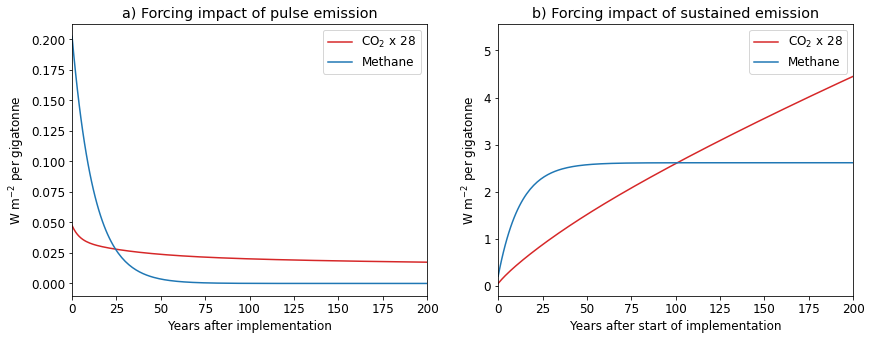

In [6]:
titles=['a) Forcing impact of pulse emission','b) Forcing impact of sustained emission']
xlabels=['Years after implementation','Years after start of implementation']
plt.figure(figsize=(14,5))
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.plot(t,F1C[:,j]*28.,color='C3',label='CO$_2$ x 28')
    plt.plot(t,F1M[:,j],color='C0',label='Methane')
    plt.xlim([0,200])
    plt.xlabel(xlabels[j])
    plt.ylabel('W m$^{-2}$ per gigatonne')
    plt.title(titles[j])
    plt.legend()

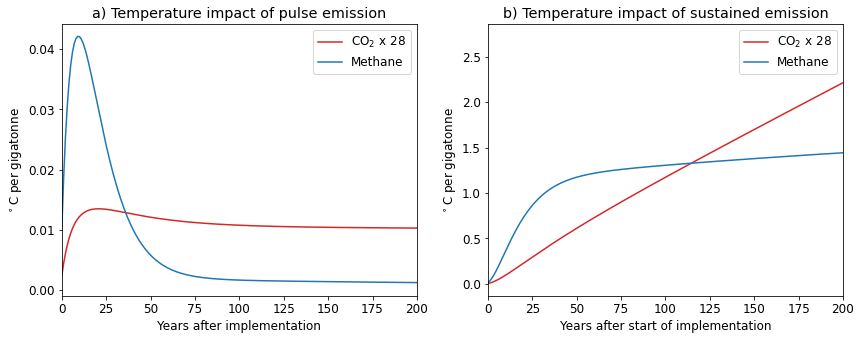

In [7]:
titles=['a) Temperature impact of pulse emission','b) Temperature impact of sustained emission']
xlabels=['Years after implementation','Years after start of implementation']
plt.figure(figsize=(14,5))
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.plot(t,T1C[:,j]*28.,color='C3',label='CO$_2$ x 28')
    plt.plot(t,T1M[:,j],color='C0',label='Methane')
    plt.xlim([0,200])
    plt.xlabel(xlabels[j])
    plt.ylabel('$^\circ$C per gigatonne')
    plt.title(titles[j])
    plt.legend()

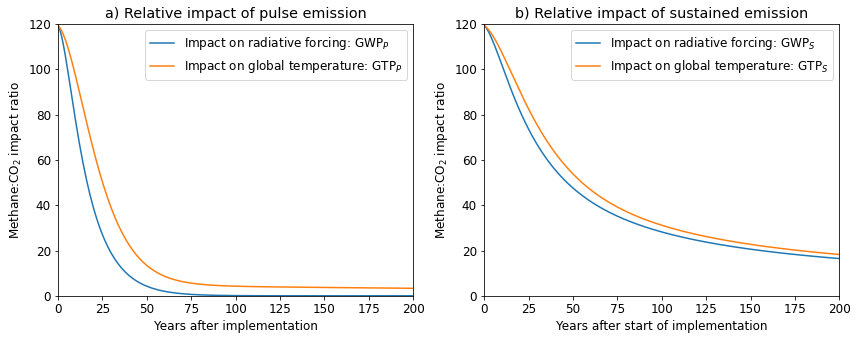

In [8]:
suffix=['$_P$','$_S$']
titles=['a) Relative impact of pulse emission','b) Relative impact of sustained emission']
xlabels=['Years after implementation','Years after start of implementation']
plt.figure(figsize=(14,5))
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.plot(t,GWP[:,j],label='Impact on radiative forcing: GWP'+suffix[j])
    plt.plot(t,GTP[:,j],label='Impact on global temperature: GTP'+suffix[j])
    plt.xlim([0,200])
    plt.ylim([0,120])
    plt.xlabel(xlabels[j])
    plt.ylabel('Methane:CO$_2$ impact ratio')
    plt.title(titles[j])
    plt.legend()

In [9]:
# Calculate GWPstar approx CO2 warming-equivalent to 1 GtCO2-e/year constant methane emission
# Note ambiguity in definition of "year 0" in GWP calculation: use average of entries H-1 and H
H=100
r=1./300
g=(1-np.exp(-r*H))/(r*H)
s=r*H/(1+r*H)
c2 = ((GWP[H-1,1]+GWP[H,1])/2)*H*g/20
c1 = ((GWP[H-1,1]+GWP[H,1])/2)*H*g*(r+1/20)
print('GWP* coeffs:',g,r,s,c1,c2)

GWP* coeffs: 0.8504060682786321 0.0033333333333333335 0.25 128.33318907666447 120.31236475937291


In [10]:
# create CO2 GWP* warming-equivalent emissions to 1 GtCH4 pulse & constant emissions
EC1s=np.zeros([ny2,2])
EC1s[0,0]=c1
EC1s[20,0]=-c2
EC1s[0:20,1]=c1
EC1s[20:,1]=(c1-c2)
# Compute forcing and temperature response
FC1s=Fco2@EC1s
TC1s=Tco2@EC1s

In [11]:
# create CH4 GWP* warming-equivalent emissions to 1 GtCO2 pulse & constant emissions
EM1s=np.zeros([ny2,2])
for j in range(0,200,20):
    EM1s[j,0]=(c2/c1)**(j/20.)/c1
    EM1s[j:,1]+=((c2/c1)**(j/20.))/c1
# Compute forcing and temperature response
FM1s=Fch4@EM1s
TM1s=Tch4@EM1s

In [12]:
# create CO2 LWE emissions equivalent to 1 GtCH4 pulse & constant emissions
ECLM=Fco2inv@F1M
# create CH4 LWE emissions equivalent to 1 GtCO2 pulse & constant emissions
EMLC=Fch4inv@F1C
# Compute temperature response
TCLM=Tco2@ECLM
TMLC=Tch4@EMLC

Values used for GWP20, GWP100 and GTP100: [83.6433300750114, 28.405145736216486, 4.25941777225773]


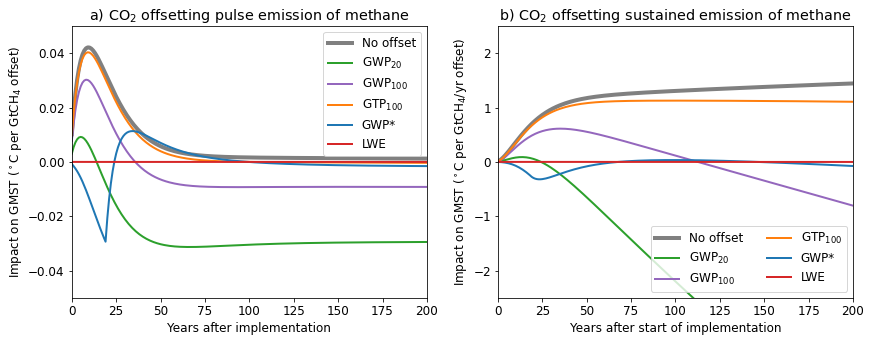

In [13]:
plt.figure(figsize=(14,5))
scfs=[GWP[19,1],GWP[99,1],GTP[99,0]]
print('Values used for GWP20, GWP100 and GTP100:',scfs)
ylim=np.array([[-0.05,0.05],[-2.5,2.5]])
labels=['No offset','GWP$_{20}$','GWP$_{100}$','GTP$_{100}$','GWP*','LWE']
colors=['grey','C2','C4','C1','C0','C3']
titles=['a) CO$_2$ offsetting pulse emission of methane','b) CO$_2$ offsetting sustained emission of methane']
xlabels=['Years after implementation','Years after start of implementation']
ylabels=['Impact on GMST ($^\circ$C per GtCH$_4$ offset)','Impact on GMST ($^\circ$C per GtCH$_4$/yr offset)']
legendloc=np.array([1,4])
legendnum=np.array([1,2])

for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.plot(t,T1M[:,j],label=labels[0],color=colors[0],linewidth=4)
    plt.xlim([0,200])
    plt.ylim(ylim[j,:])
    plt.title(titles[j])
    plt.xlabel(xlabels[j])
    plt.ylabel(ylabels[j])
    for i in range (3):
        plt.plot(t,T1M[:,j]-T1C[:,j]*scfs[i],label=labels[i+1],color=colors[i+1],linewidth=2)
    plt.plot(t,T1M[:,j]-TC1s[:,j],label=labels[4],color=colors[4],linewidth=2)
    plt.plot(t,T1M[:,j]-TCLM[:,j],label=labels[5],color=colors[5],linewidth=2)
#    plt.legend(loc='best', framealpha=0.0, edgecolor=None, ncol=legendnum[j])
    plt.legend(loc='best', ncol=legendnum[j], framealpha=0.8)
plt.savefig('ITMO_fig1.png', dpi=600, bbox_inches='tight')


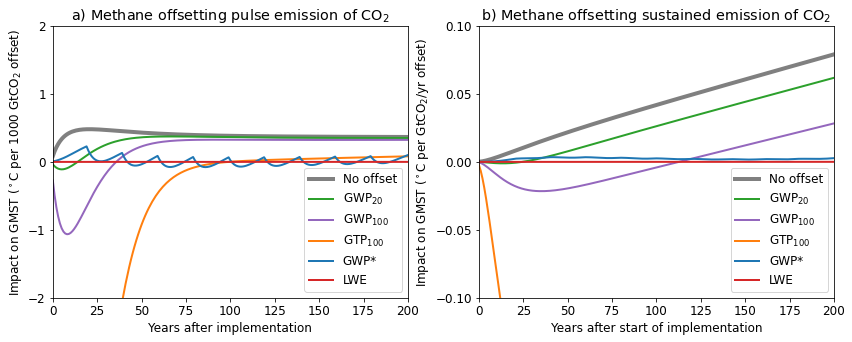

In [14]:
plt.figure(figsize=(14,5))
scfs=np.array([[1000./GWP[19,1],1000./GWP[99,1],1000./GTP[99,0],1000.],[1./GWP[19,1],1./GWP[99,1],1./GTP[99,0],1.]])
ylim=np.array([[-2,2],[-0.1,0.1]])
titles=['a) Methane offsetting pulse emission of CO$_2$','b) Methane offsetting sustained emission of CO$_2$']
xlabels=['Years after implementation','Years after start of implementation']
ylabels=['Impact on GMST ($^\circ$C per 1000 GtCO$_2$ offset)','Impact on GMST ($^\circ$C per GtCO$_2$/yr offset)']
yticks=np.array([[-2,-1,0,1,2],[-0.1,-0.05,0,0.05,0.1]])
legendloc=np.array([4,4])
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.plot(t,T1C[:,j]*scfs[j,3],label=labels[0],color=colors[0],linewidth=4)
    plt.xlim([0,200])
    plt.ylim(ylim[j,:])
    plt.yticks(yticks[j,:])
    plt.title(titles[j])
    plt.xlabel(xlabels[j])
    plt.ylabel(ylabels[j])
    for i in range (3):
        plt.plot(t,T1C[:,j]*scfs[j,3]-T1M[:,j]*scfs[j,i],label=labels[i+1],color=colors[i+1],linewidth=2)
    plt.plot(t,(T1C[:,j]-TM1s[:,j])*scfs[j,3],label=labels[4],color=colors[4],linewidth=2)
    plt.plot(t,(T1C[:,j]-TMLC[:,j])*scfs[j,3],label=labels[5],color=colors[5],linewidth=2)
    plt.legend(loc=legendloc[j])
plt.savefig('ITMO_fig2.png', dpi=600, bbox_inches='tight')

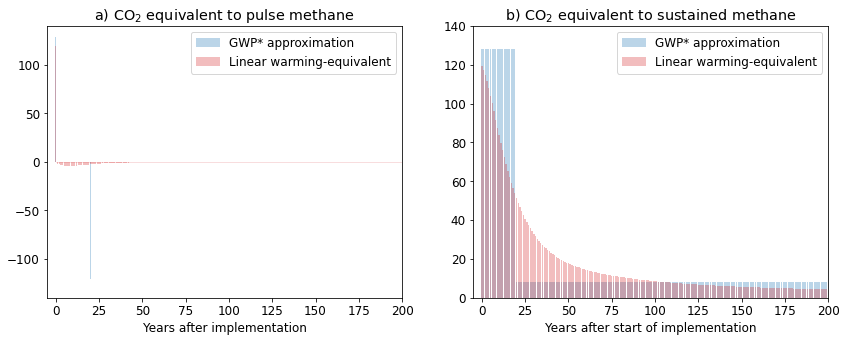

In [15]:
plt.figure(figsize=(14,5))
scfs=[1.,1.]
ylim=np.array([[-140,140],[0,140]])
labels=['GWP* approximation','Linear warming-equivalent']
titles=['a) CO$_2$ equivalent to pulse methane','b) CO$_2$ equivalent to sustained methane']
xlabels=['Years after implementation','Years after start of implementation']
ylabels=['Emissions (MtCO$_2$ per MtCH$_4$)','Emissions (MtCO$_2$ per MtCH$_4$/yr)']
legendloc=np.array([1,4])
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.bar(t,EC1s[:,j],label=labels[0], color='C0', alpha=0.3)
    plt.bar(t,ECLM[:,j],label=labels[1], color='C3', alpha=0.3)
    plt.plot(t,ECLM[:,j]*0.,color='C3', alpha=0.3, linewidth=0.5)
    plt.title(titles[j])
    plt.xlabel(xlabels[j])
    plt.xlim([-5,200])
    plt.ylim(ylim[j,:])
    plt.legend(loc='best')
plt.savefig('ITMO_fig3.png', dpi=600, bbox_inches='tight')

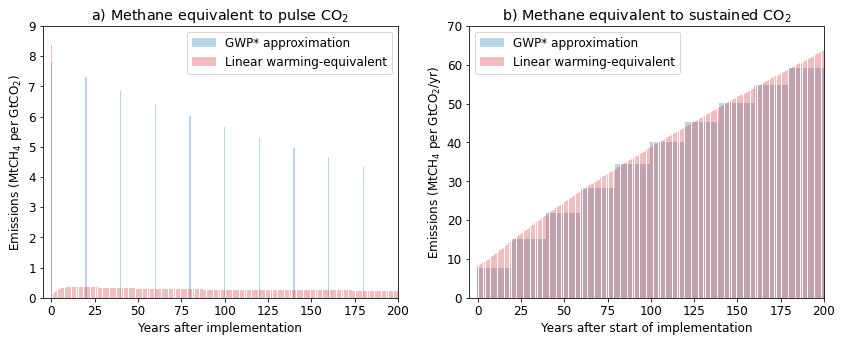

In [16]:
plt.figure(figsize=(14,5))
scfs=[1.,1.]
ylim=np.array([[0,9],[0,70]])
labels=['GWP* approximation','Linear warming-equivalent']
titles=['a) Methane equivalent to pulse CO$_2$','b) Methane equivalent to sustained CO$_2$']
xlabels=['Years after implementation','Years after start of implementation']
ylabels=['Emissions (MtCH$_4$ per GtCO$_2$)','Emissions (MtCH$_4$ per GtCO$_2$/yr)']
legendloc=np.array([1,4])
for j in [0,1]:
    plt.subplot(1,2,j+1)
    plt.bar(t,EM1s[:,j]*1000.,label=labels[0], color='C0', alpha=0.3)
    plt.bar(t,EMLC[:,j]*1000.,label=labels[1], color='C3', alpha=0.3)
    plt.title(titles[j])
    plt.xlabel(xlabels[j])
    plt.ylabel(ylabels[j])
    plt.xlim([-5,200])
    plt.ylim(ylim[j,:])
    plt.legend(loc='best')
plt.savefig('ITMO_fig4.png', dpi=600, bbox_inches='tight')

In [17]:
MED15=pd.read_csv('IAMC_med15_plushist.csv',index_col=0,header=0,skiprows=3)
t2=MED15.index
Eco2=np.array(MED15['co2'].values)*44./12.
Ech4=np.array(MED15['ch4'].values)/1000.
Eplt=np.zeros((ny2,6,2))
Eplt[:,0,0]=Eco2
scfs=[GWP[19,1],GWP[99,1],GTP[99,0]]
for i in range(3):
    Eplt[:,i+1,0]=Ech4*scfs[i]
Ech4s=np.copy(Ech4)
Ech4s[20:]=Ech4[20:]*c1-Ech4[0:ny2-20]*c2
Ech4s[0:20]=Ech4[0:20]*c1
Eplt[:,4,0]=Ech4s
Eplt[:,5,0]=Fco2inv@Fch4@Ech4
Eplt[:,:,1]=np.cumsum(Eplt[:,:,0],axis=0)/1000.
TEco2=Tco2@Eco2
TEch4=Tch4@Ech4
TCRE=1000.*max(TEco2)/max(np.cumsum(Eco2))
print('TCRE:',TCRE)

TCRE: 0.4244551680645083


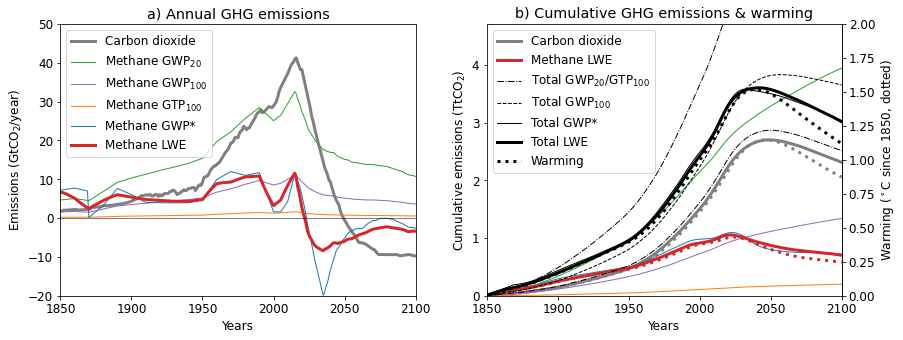

In [18]:
fig = plt.figure(figsize=(14,5))
labels=['Carbon dioxide','Methane GWP$_{20}$','Methane GWP$_{100}$','Methane GTP$_{100}$','Methane GWP*','Methane LWE']
titles=['a) Annual GHG emissions','b) Cumulative GHG emissions & warming']
ylabels=['Emissions (GtCO$_2$/year)','Cumulative emissions (TtCO$_2$)']
ylim=np.array([[-20,50],[0,2/TCRE]])
legendloc=np.array([2,2])
linewidth=[3,1,1,1,1,3]
def E2T(x):
    return x * TCRE
def T2E(x):
    return x / TCRE

for j in [0,1]:
    ax = fig.add_subplot(121+j)
    for i in range (6):
        if j == 1 and i > 0 and i < 5:
            line,=ax.plot(t2,Eplt[:,i,j],color=colors[i],linewidth=linewidth[i])
        else:
            line,=ax.plot(t2,Eplt[:,i,j],label=labels[i],color=colors[i],linewidth=linewidth[i])
        if j == 1 and i == 0:
            ax.plot(t2,TEco2/TCRE,color = colors[i], linestyle = ':', linewidth=linewidth[i])
        if j == 1 and i == 5:
            ax.plot(t2,TEch4/TCRE,color = colors[i], linestyle = ':', linewidth=linewidth[i])
    if j == 1:
        ax.plot(t2,Eplt[:,0,j]+Eplt[:,1,j],color = 'black', linestyle = '-.', linewidth=linewidth[1], label='Total GWP$_{20}$/GTP$_{100}$')
        ax.plot(t2,Eplt[:,0,j]+Eplt[:,2,j],color = 'black', linestyle = '--', linewidth=linewidth[2], label='Total GWP$_{100}$')
        ax.plot(t2,Eplt[:,0,j]+Eplt[:,3,j],color = 'black', linestyle = '-.', linewidth=linewidth[3])
        ax.plot(t2,Eplt[:,0,j]+Eplt[:,4,j],color = 'black', linewidth=linewidth[4], label='Total GWP*')
        ax.plot(t2,Eplt[:,0,j]+Eplt[:,5,j],color = 'black', linewidth=linewidth[5], label='Total LWE')
        ax.plot(t2,(TEch4+TEco2)/TCRE,color = 'black', linestyle = ':', linewidth=linewidth[5], label='Warming')
    ax.plot(t2,t2*0.,linewidth=0.5,color='black')
    plt.xlim([1850,2100])
    plt.ylim(ylim[j,:])
    plt.title(titles[j])
    plt.xlabel('Years')
    plt.ylabel(ylabels[j])
    plt.legend(loc=legendloc[j])
secax = ax.secondary_yaxis('right', functions=(E2T, T2E))
secax.set_ylabel('Warming ($^\circ$C since 1850, dotted)')
plt.savefig('ITMO_fig5.png', dpi=600, bbox_inches='tight')